In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import contextily as ctx
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import pandas as pd
import numpy as np

KeyboardInterrupt: 

Filtering 2012-2024 Data Corsica

In [ ]:
# Carica i file GeoJSON
corsica_fp = gpd.read_file('Corsica\export_FDF_FDFP.geojson')
corsica_fa = gpd.read_file('Corsica\export_FDF_FDFS.geojson')

# Converti la colonna 'date_depar' in formato datetime, gestendo eventuali errori
corsica_fp['date_depar'] = pd.to_datetime(corsica_fp['date_depar'], errors='coerce')
corsica_fa['date_depar'] = pd.to_datetime(corsica_fa['date_depar'], errors='coerce')

# Definisci l'intervallo di date
start_date = '2012-01-01'
end_date = '2024-12-31'

# Filtra i GeoDataFrame per includere solo le righe nell'intervallo di date
fp_filtered = corsica_fp[(corsica_fp['date_depar'] >= start_date) & (corsica_fp['date_depar'] <= end_date)]
fa_filtered = corsica_fa[(corsica_fa['date_depar'] >= start_date) & (corsica_fa['date_depar'] <= end_date)]

fp_filtered.to_file("corsica_2012_2024/corsica_fp.geojson", driver="GeoJSON")
fa_filtered.to_file("corsica_2012_2024/corsica_fa.geojson",driver="GeoJSON")
print(len(fp_filtered))
print(len(fa_filtered))


5765
323


Cutting Corsica from EFFIS Json (run only to get the new file)

In [ ]:
effis = gpd.read_file("../EFFIS_IT_EL_FR_PT_2021_2024\EFFIS_IT_EL_FR_PT_2021_2024.json")

#Filtering for corsica data
effis_corsica = effis[
    (effis["country"] == "France") & 
    (
        (effis["admlvl1"].str.contains("Corse", case=False)) |
        (effis["admlvl2"].str.contains("Corse", case=False))
    )
]
effis_corsica=effis_corsica.to_crs(epsg=4326)
print(len(effis_corsica))

effis_corsica.to_file("corsica_2012_2024/effis_corsica.geojson", driver="GeoJSON")

Comparison of different data

EPSG:3857
EPSG:3857
EPSG:3857


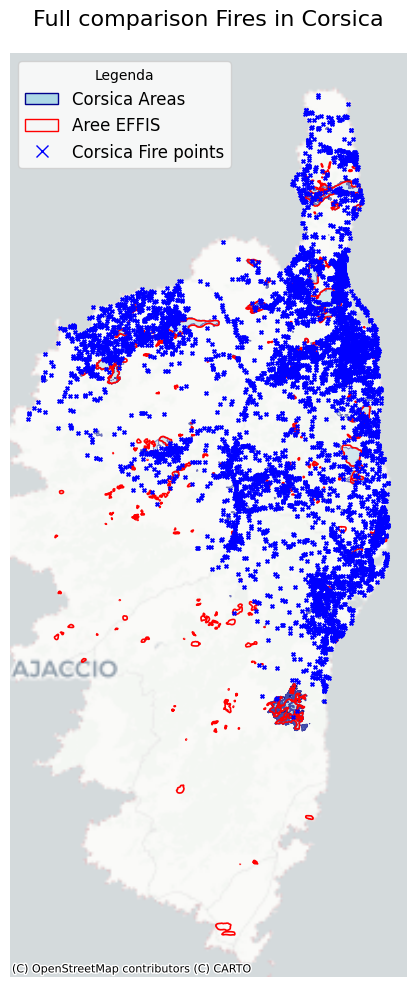

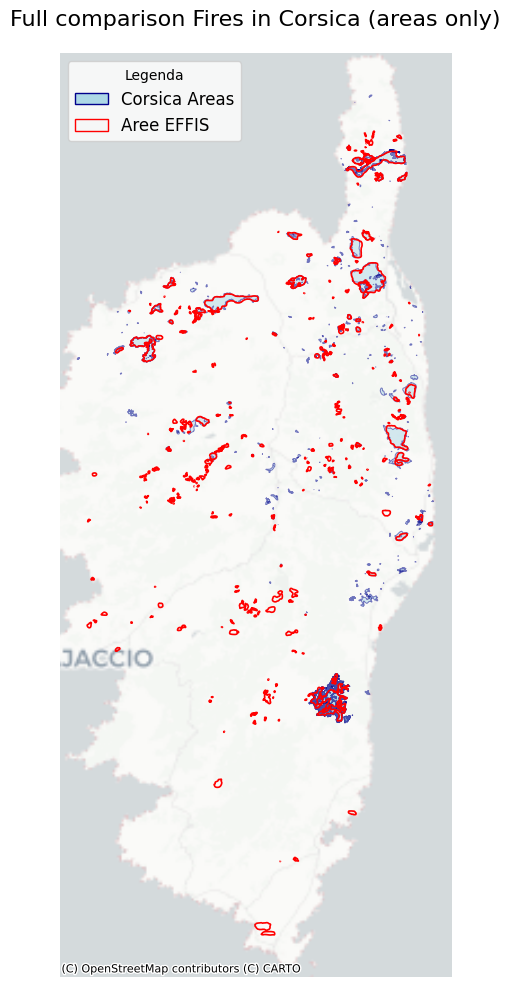

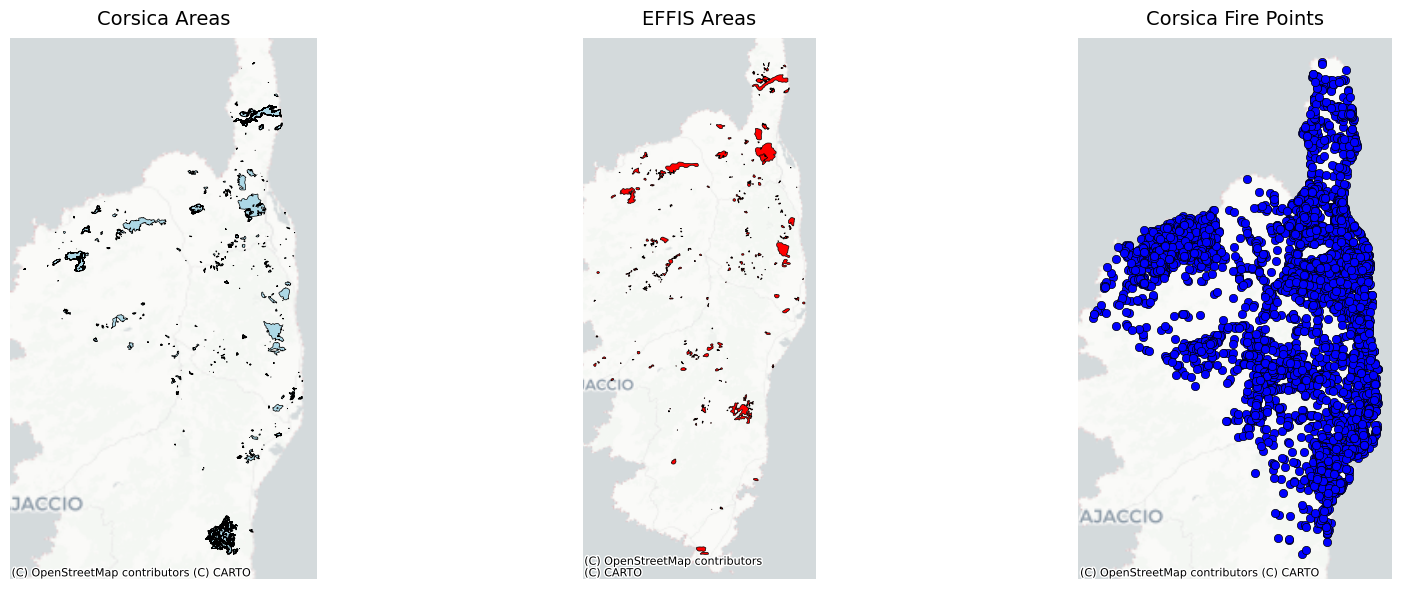

In [39]:

#####Composed Map
effis_corsica=gpd.read_file("corsica_2012_2024/effis_corsica.geojson")
corsica_fa=gpd.read_file("corsica_2012_2024/corsica_fa.geojson")
corsica_fp=gpd.read_file("corsica_2012_2024/corsica_fp.geojson")

# Convert to Web Mercator for plotting
effis_corsica = effis_corsica.to_crs(epsg=3857)
corsica_fa = corsica_fa.to_crs(epsg=3857)
corsica_fp = corsica_fp.to_crs(epsg=3857)


print(corsica_fp.crs)
print(corsica_fa.crs)
print(effis_corsica.crs)


fig = plt.figure(figsize=(22, 22))
gs = gridspec.GridSpec(2, 1, height_ratios=[1.5, 1])


ax_main = fig.add_subplot(gs[0])

#1. Fire areas Corsica
corsica_fa.plot(
    ax=ax_main,
    facecolor="lightblue",
    edgecolor="darkblue",
    alpha=0.5,
    linewidth=0.7
)

#2. EFFIS fire areas
effis_corsica.plot(
    ax=ax_main,
    facecolor="none",
    edgecolor="red",
    linewidth=1.2
)

#3. Corsica Fire  Points
corsica_fp.plot(
    ax=ax_main,
    color="blue",
    markersize=7,
    marker="x"
)

# Base map and title
ctx.add_basemap(ax_main, source=ctx.providers.CartoDB.Positron, zoom=8)
ax_main.set_title("Full comparison Fires in Corsica", fontsize=16, pad=20)
ax_main.axis("off")

#MANUAL LEGEND
legend_elements = [
    mpatches.Patch(facecolor="lightblue", edgecolor="darkblue", label="Corsica Areas"),
    mpatches.Patch(facecolor="none", edgecolor="red", label="Aree EFFIS"),
    mlines.Line2D([], [], color="blue", marker="x", markersize=8, linestyle="None", label="Corsica Fire points")
]

ax_main.legend(handles=legend_elements, loc='upper left', frameon=True, fontsize=12, title="Legenda")

#####Composed Map only AREAS
fig1 = plt.figure(figsize=(22, 22))
gs1 = gridspec.GridSpec(2, 1, height_ratios=[1.5, 1])


ax_main1 = fig1.add_subplot(gs[0])

#1. Fire areas Civil Protection
corsica_fa.plot(
    ax=ax_main1,
    facecolor="lightblue",
    edgecolor="darkblue",
    alpha=0.5,
    linewidth=0.7
)

#2. EFFIS fire areas
effis_corsica.plot(
    ax=ax_main1,
    facecolor="none",
    edgecolor="red",
    linewidth=1.2
)


# Base map and title
ctx.add_basemap(ax_main1, source=ctx.providers.CartoDB.Positron, zoom=8)
ax_main1.set_title("Full comparison Fires in Corsica (areas only)", fontsize=16, pad=20)
ax_main1.axis("off")

#MANUAL LEGEND
legend_elements = [
    mpatches.Patch(facecolor="lightblue", edgecolor="darkblue", label="Corsica Areas"),
    mpatches.Patch(facecolor="none", edgecolor="red", label="Aree EFFIS")]

ax_main1.legend(handles=legend_elements, loc='upper left', frameon=True, fontsize=12, title="Legenda")

#################3 SEPARATE GRAPHS (NEXT TO EACH OTHER)
fig2, ax_sub = plt.subplots(1, 3, figsize=(18, 6) )

datasets = [
    (corsica_fa, "Corsica Areas", "lightblue"),
    (effis_corsica, "EFFIS Areas", "red"),
    (corsica_fp, "Corsica Fire Points", "blue")
    
]

# Plot per ogni dataset
for ax, (data, title, color) in zip(ax_sub, datasets):
    if "Punti" in title:
        data.plot(ax=ax, markersize=10, marker="x", color=color)
    else:
        data.plot(ax=ax, facecolor=color, edgecolor="black", linewidth=0.5)

    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, zoom=8)
    ax.set_title(title, fontsize=14, pad=10)
    ax.axis("off")

plt.tight_layout()
plt.show()

Geographic Distribution, Burned Area Dimension

EFFIS area: 20666.1 ha
Corsica area: 18680.7 ha
Overlapping area: 13269.5 ha
EFFIS only area: 7396.6 ha
Corsica only area: 5411.3 ha


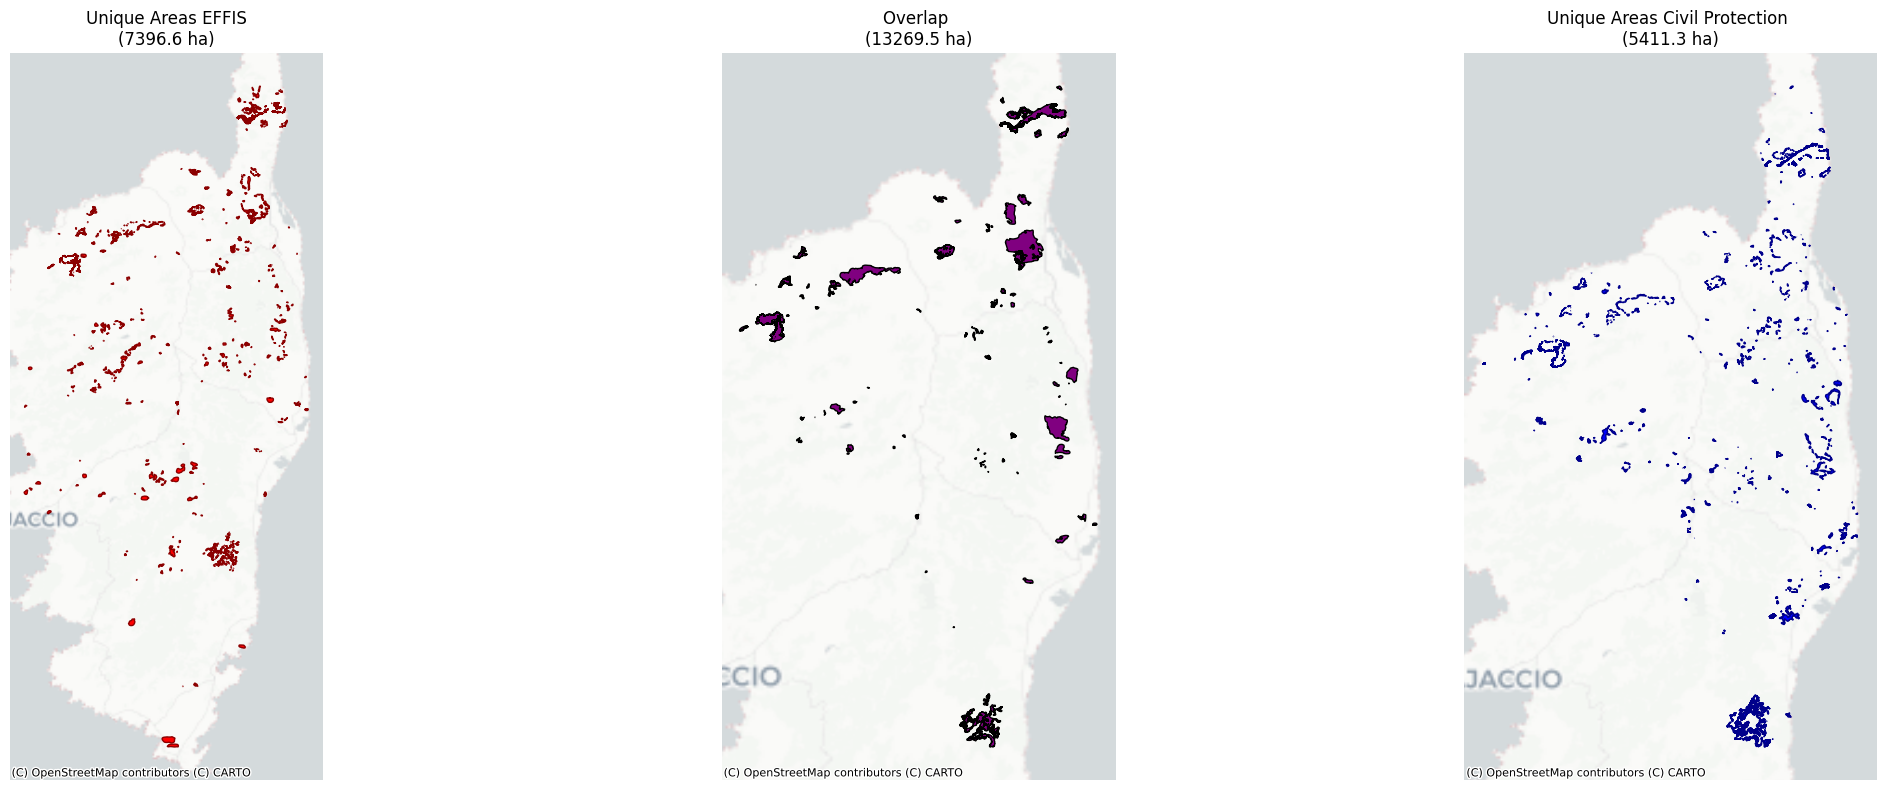

In [33]:
from shapely.ops import unary_union

#Load data
effis_corsica = gpd.read_file("corsica_2012_2024/effis_corsica.geojson").to_crs(epsg=32631)
corsica_fa = gpd.read_file("corsica_2012_2024/corsica_fa.geojson").to_crs(epsg=32631)
# Fix geometries
corsica_fa["geometry"] = corsica_fa["geometry"].buffer(0)

#Unary Union computation
effis_union = unary_union(effis_corsica.geometry)
cp_union = unary_union(corsica_fa.geometry)

#Areas computation
area_effis = effis_union.area / 10_000
area_pc = cp_union.area / 10_000

#Overlapping and unique areas
overlap_geometry = effis_union.intersection(cp_union)
effis_unique_geometry = effis_union.difference(cp_union)
cp_unique_geometry = cp_union.difference(effis_union)

overlap_area = overlap_geometry.area / 10_000
effis_unique = effis_unique_geometry.area / 10_000
cp_unique = cp_unique_geometry.area / 10_000

#Aritmetical results
print(f"EFFIS area: {area_effis:.1f} ha")
print(f"Corsica area: {area_pc:.1f} ha")
print(f"Overlapping area: {overlap_area:.1f} ha")
print(f"EFFIS only area: {effis_unique:.1f} ha")
print(f"Corsica only area: {cp_unique:.1f} ha")

fig, axs = plt.subplots(1, 3, figsize=(25, 8))

#Unique EFFIS
gpd.GeoDataFrame(geometry=[effis_unique_geometry],crs="EPSG:32631").to_crs(epsg=3857).plot(
    ax=axs[0], 
    color="red",
    edgecolor="darkred"
)
axs[0].set_title(f"Unique Areas EFFIS\n({effis_unique:.1f} ha)")

#Overlap
gpd.GeoDataFrame(geometry=[overlap_geometry],crs="EPSG:32631").to_crs(epsg=3857).plot(
    ax=axs[1], 
    color="purple",
    edgecolor="black"
)
axs[1].set_title(f"Overlap \n({overlap_area:.1f} ha)")

#Unique CP
gpd.GeoDataFrame(geometry=[cp_unique_geometry],crs="EPSG:32631").to_crs(epsg=3857).plot(
    ax=axs[2], 
    color="blue",
    edgecolor="darkblue"
)
axs[2].set_title(f"Unique Areas Civil Protection \n({cp_unique:.1f} ha)")

#basemap
for ax in axs:
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron,zoom=8)
    ax.axis("off")

plt.tight_layout()
plt.show()

Temporal Distribution and Seasonal Distribution

323
5761
317


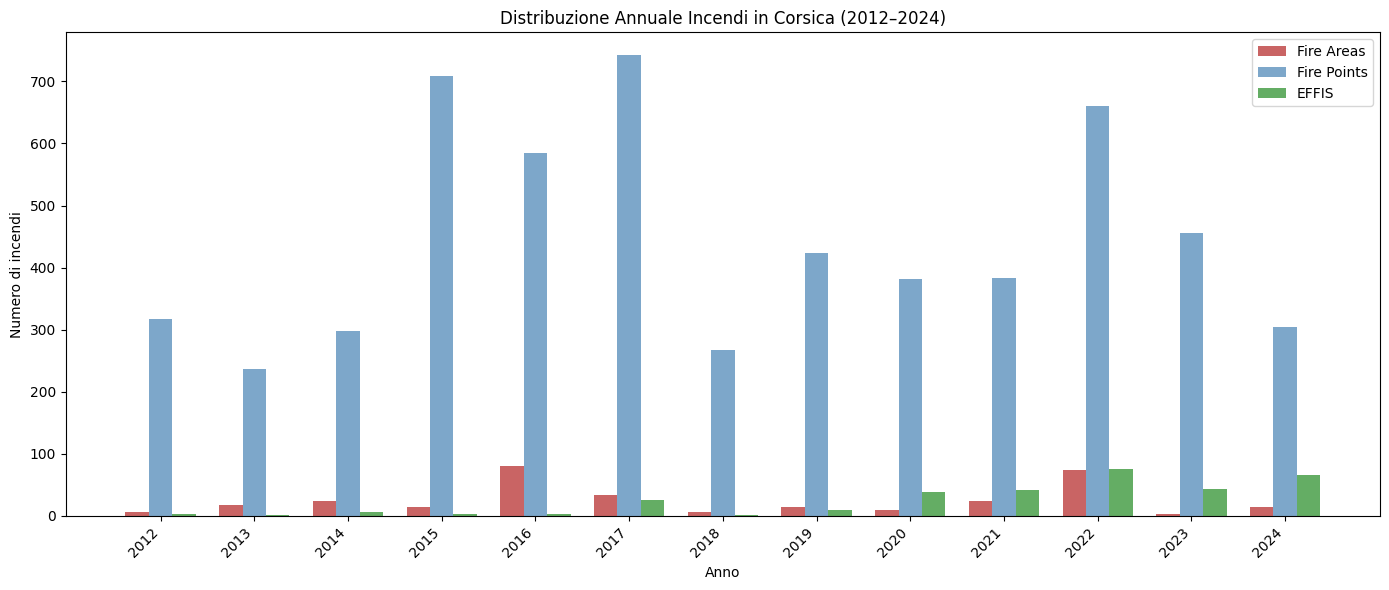

<Figure size 640x480 with 0 Axes>

---FA---
winter : 43
spring : 46
summer : 172
autumn : 62
---FP---:
winter : 1064
spring : 1332
summer : 1857
autumn : 1508
---FP+FA---
winter : 1107
spring : 1378
summer : 2029
autumn : 1570


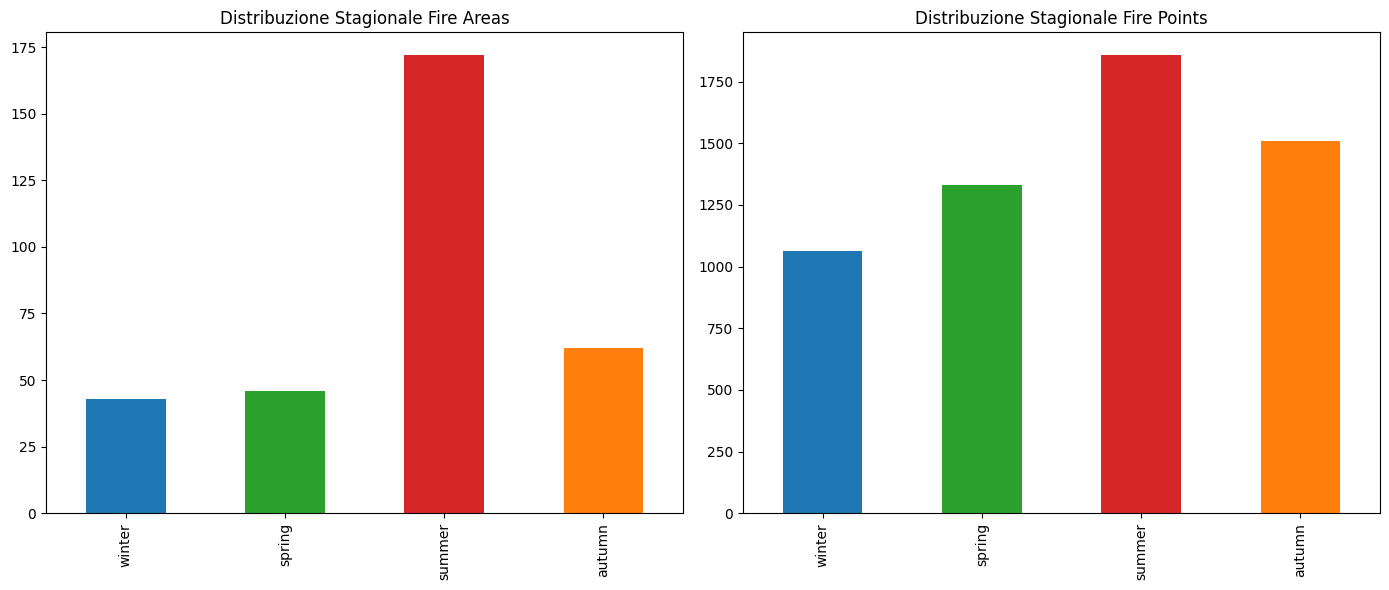

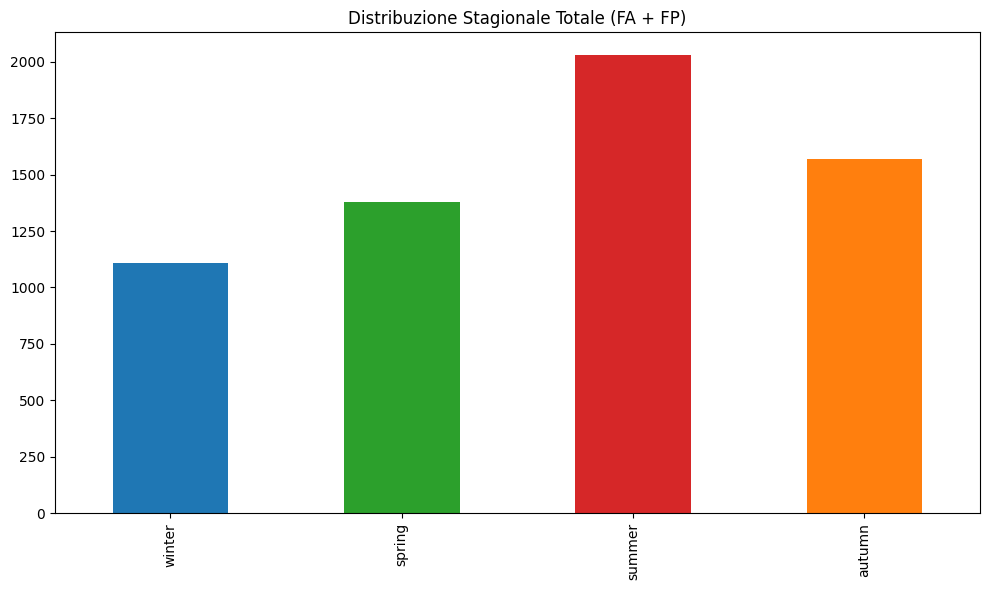

In [46]:
# Caricamento dati
corsica_fa = gpd.read_file("corsica_2012_2024/corsica_fa.geojson")
print(len(corsica_fa))
corsica_fp = gpd.read_file("corsica_2012_2024/corsica_fp.geojson")
print(len(corsica_fp))
effis_corsica = gpd.read_file("corsica_2012_2024/effis_corsica.geojson")
print(len(effis_corsica))

# Converto le date in datetime
corsica_fa["date_depar"] = pd.to_datetime(corsica_fa["date_depar"], errors='coerce')
corsica_fp["date_depar"] = pd.to_datetime(corsica_fp["date_depar"], errors='coerce')
effis_corsica["intialdate"] = pd.to_datetime(effis_corsica["initialdate"], errors='coerce')  # <-- qui il nome della colonna

# Aggiungo colonna "year"
corsica_fa["year"] = corsica_fa["date_depar"].dt.year
corsica_fp["year"] = corsica_fp["date_depar"].dt.year
effis_corsica["year"] = effis_corsica["intialdate"].dt.year

corsica_fa["month"] = corsica_fa["date_depar"].dt.month
corsica_fp["month"] = corsica_fp["date_depar"].dt.month

### ANALISI ANNUALE ###
years_range = range(2012, 2025)

annual_fa = corsica_fa["year"].value_counts().reindex(years_range, fill_value=0).sort_index()
annual_fp = corsica_fp["year"].value_counts().reindex(years_range, fill_value=0).sort_index()
annual_effis = effis_corsica["year"].value_counts().reindex(years_range, fill_value=0).sort_index()

# Plot
fig, ax = plt.subplots(figsize=(14, 6))
bar_width = 0.25

index = np.arange(len(years_range))

# Barre affiancate
ax.bar(index - bar_width, annual_fa, bar_width, 
       color="firebrick", alpha=0.7, label="Fire Areas")
ax.bar(index, annual_fp, bar_width, 
       color="steelblue", alpha=0.7, label="Fire Points")
ax.bar(index + bar_width, annual_effis, bar_width, 
       color="forestgreen", alpha=0.7, label="EFFIS")

# Formattazione grafico
plt.title("Distribuzione Annuale Incendi in Corsica (2012–2024)")
plt.xlabel("Anno")
plt.ylabel("Numero di incendi")
plt.xticks(index, labels=years_range)
plt.legend()

plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()

### ANALISI STAGIONALE ###
seasons = {
    'winter': [12, 1, 2],
    'spring': [3, 4, 5],
    'summer': [6, 7, 8],
    'autumn': [9, 10, 11]
}

# Funzione per contare per stagione
def count_by_season(gdf):
    counts = {}
    for season, months in seasons.items():
        counts[season] = gdf[gdf["month"].isin(months)].shape[0]
    return counts

season_counts_fa = count_by_season(corsica_fa)
print("---FA---")
for season in seasons.keys():
    print(f"{season} : {season_counts_fa[season]}")
season_counts_fp = count_by_season(corsica_fp)
print("---FP---:")
for season in seasons.keys():
    print(f"{season} : {season_counts_fp[season]}")
season_counts_total = {s: season_counts_fa[s] + season_counts_fp[s] for s in seasons.keys()}
print("---FP+FA---")
for season in seasons.keys():
    print(f"{season} : {season_counts_total[season]}")

# Plot stagionale
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

pd.Series(season_counts_fa).plot(
    kind='bar',
    color=['#1f77b4', '#2ca02c', '#d62728', '#ff7f0e'],
    ax=ax1,
    title='Distribuzione Stagionale Fire Areas'
)

pd.Series(season_counts_fp).plot(
    kind='bar',
    color=['#1f77b4', '#2ca02c', '#d62728', '#ff7f0e'],
    ax=ax2,
    title='Distribuzione Stagionale Fire Points'
)

plt.tight_layout()
plt.show()

# Plot totale
fig, ax = plt.subplots(figsize=(10, 6))

pd.Series(season_counts_total).plot(
    kind='bar',
    color=['#1f77b4', '#2ca02c', '#d62728', '#ff7f0e'],
    ax=ax,
    title='Distribuzione Stagionale Totale (FA + FP)'
)

plt.tight_layout()
plt.show()


Fire Points and Fire Areas Area distrbution

Fire Areas (FA) Statistics:
count     300.000000
mean       82.696667
std       369.553411
min         0.000000
25%         1.000000
50%         5.000000
75%        22.000000
max      3124.000000
Name: area_ha, dtype: float64

Fire Points (FP) Statistics:
count    5761.000000
mean        3.135608
std        48.823494
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      2118.000000
Name: area_ha, dtype: float64


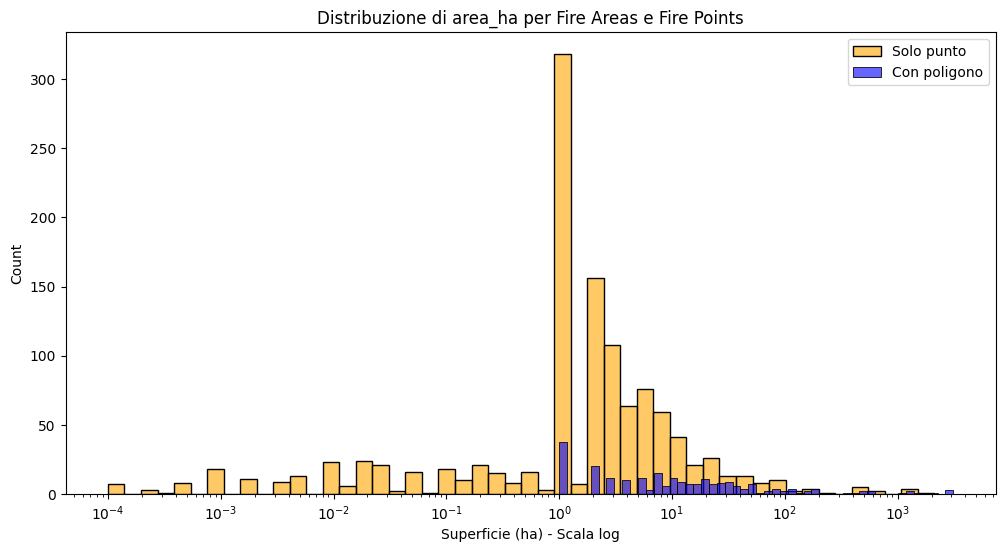

In [51]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

# Caricare i dati
corsica_fa = gpd.read_file("corsica_2012_2024/corsica_fa.geojson")
corsica_fp = gpd.read_file("corsica_2012_2024/corsica_fp.geojson")

# Assicurarsi che 'area_ha' sia numerico
corsica_fa["area_ha"] = pd.to_numeric(corsica_fa["superficie"], errors="coerce")
corsica_fp["area_ha"] = pd.to_numeric(corsica_fp["superficie"], errors="coerce")

# 1. Statistiche descrittive
print("Fire Areas (FA) Statistics:")
print(corsica_fa["area_ha"].describe())

print("\nFire Points (FP) Statistics:")
print(corsica_fp["area_ha"].describe())

# 2. Istogrammi
plt.figure(figsize=(12,6))
sns.histplot(corsica_fp["area_ha"], bins=50, color="orange", alpha=0.6, label="Solo punto", log_scale=True)
sns.histplot(corsica_fa["area_ha"], bins=50, color="blue", alpha=0.6, label="Con poligono", log_scale=True)
plt.legend()
plt.title("Distribuzione di area_ha per Fire Areas e Fire Points")
plt.xlabel("Superficie (ha) - Scala log")
plt.show()



Season Burned Area


Seasonal Burned Area (Fire Areas connected to Fire Points):
winter    13618.0
spring      478.0
summer     7218.0
autumn     3495.0
dtype: float64

Seasonal Burned Area (Fire Points without Fire Area):
winter    4199.9360
spring    1065.7830
summer    7401.1816
autumn    5397.3391
dtype: float64

Seasonal Burned Area Total:
winter    17817.9360
spring     1543.7830
summer    14619.1816
autumn     8892.3391
dtype: float64


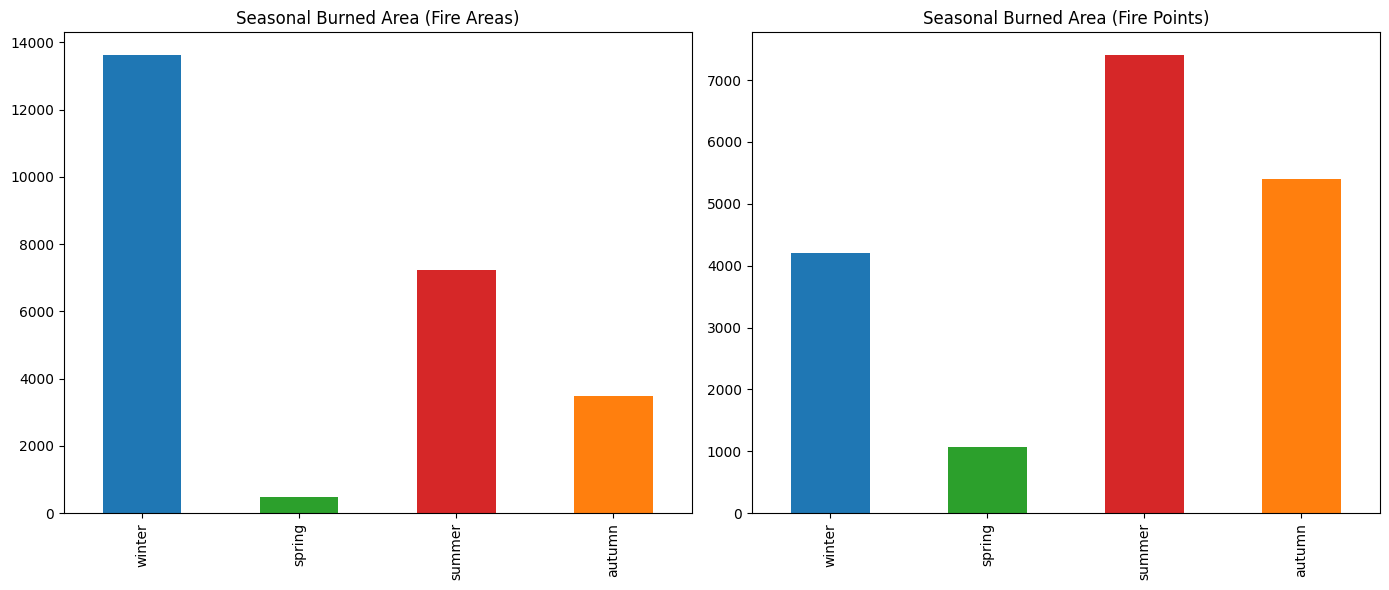

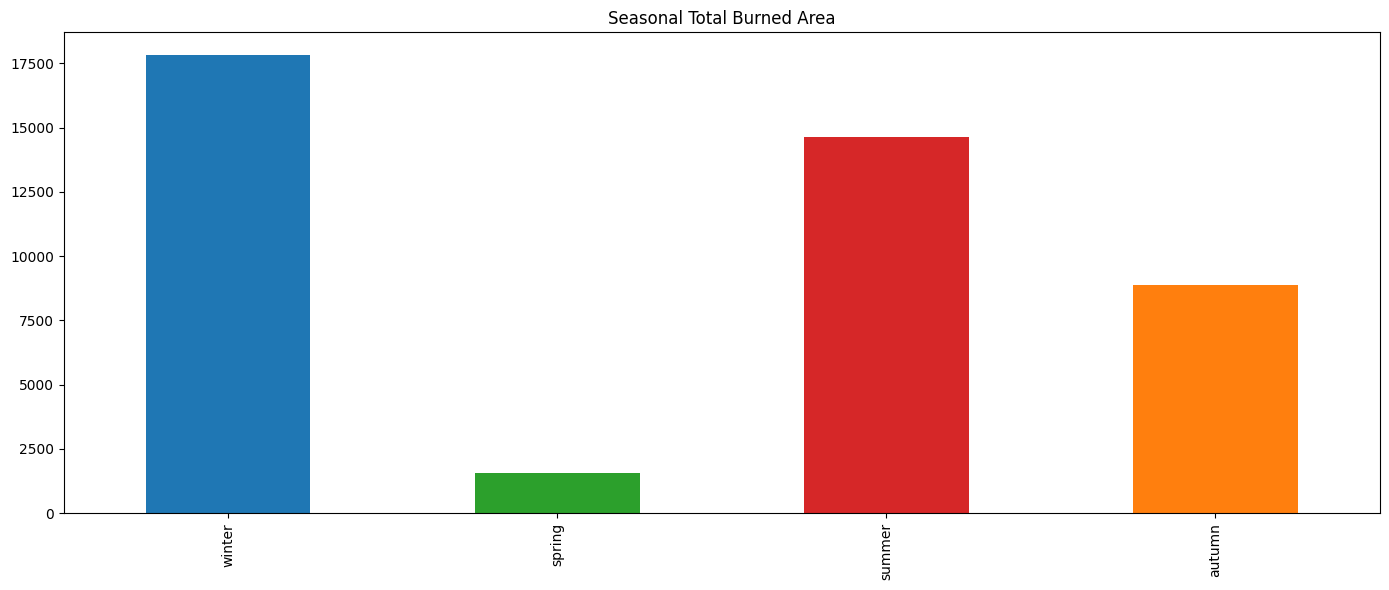

In [48]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Caricamento dati
corsica_fa = gpd.read_file("corsica_2012_2024/corsica_fa.geojson")
corsica_fp = gpd.read_file("corsica_2012_2024/corsica_fp.geojson")


# Convertire le date in mesi
corsica_fa["month"] = pd.to_datetime(corsica_fa["date_depar"], errors='coerce').dt.month
corsica_fp["month"] = pd.to_datetime(corsica_fp["date_depar"], errors='coerce').dt.month

# Definizione delle stagioni
seasons = {
    'winter': [12, 1, 2],
    'spring': [3, 4, 5],
    'summer': [6, 7, 8],
    'autumn': [9, 10, 11]
}

# Inizializzare i dizionari per la somma delle aree bruciate
season_area_fa = {season: 0 for season in seasons}
season_area_fp = {season: 0 for season in seasons}
season_area_total = {season: 0 for season in seasons}

# Sommare l'area bruciata per stagione
for season, months in seasons.items():
    season_area_fa[season] = corsica_fa.loc[corsica_fa["month"].isin(months), "superficie"].sum()
    season_area_fp[season] = corsica_fp.loc[corsica_fp["month"].isin(months), "superficie"].sum()
    season_area_total[season] = season_area_fa[season] + season_area_fp[season]

# Stampare i risultati
print("\nSeasonal Burned Area (Fire Areas connected to Fire Points):")
print(pd.Series(season_area_fa))

print("\nSeasonal Burned Area (Fire Points without Fire Area):")
print(pd.Series(season_area_fp))

print("\nSeasonal Burned Area Total:")
print(pd.Series(season_area_total))

# Creazione dei grafici
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Fire Areas
pd.Series(season_area_fa).plot(
    kind='bar', 
    color=['#1f77b4', '#2ca02c', '#d62728', '#ff7f0e'],
    ax=ax1,
    title='Seasonal Burned Area (Fire Areas)'
)

# Fire Points
pd.Series(season_area_fp).plot(
    kind='bar', 
    color=['#1f77b4', '#2ca02c', '#d62728', '#ff7f0e'],
    ax=ax2,
    title='Seasonal Burned Area (Fire Points)'
)

plt.tight_layout()
plt.show()

fig1, ax = plt.subplots(figsize=(14, 6))

pd.Series(season_area_total).plot(
    kind='bar', 
    color=['#1f77b4', '#2ca02c', '#d62728', '#ff7f0e'],
    ax=ax,
    title='Seasonal Total Burned Area'
)

plt.tight_layout()
plt.show()


POSSIBILE MATCH SU NUM_PROMETH, MA CI SONO SUPERFICI DIVERSE, STRANGE